## Importing functions

In [125]:
import os
import pandas as pd
import zipfile
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt
import numpy as np


# Functions to load the data

In [126]:
data_folder = "data"

# 1. Load bus routes data from CSV file
def load_bus_routes_data():
    bus_routes_path = os.path.join(data_folder, "bus_routes_data.csv")
    if os.path.exists(bus_routes_path):
        bus_routes_df = pd.read_csv(bus_routes_path)
        return bus_routes_df
    else:
        print(f"Error: {bus_routes_path} not found.")
        return None

# 2. Load bus stops data from CSV file and convert to GeoDataFrame
def load_bus_stops_data():
    bus_stops_path = os.path.join(data_folder, "bus_stops_data.csv")
    if os.path.exists(bus_stops_path):
        bus_stops_df = pd.read_csv(bus_stops_path)
        # Create a GeoDataFrame for bus stops with Point geometries from Longitude and Latitude
        bus_stops_gdf = gpd.GeoDataFrame(
            bus_stops_df,
            geometry=gpd.points_from_xy(bus_stops_df['Longitude'], bus_stops_df['Latitude']),
            crs='EPSG:4326'
        )
        print("Bus Stops Data Loaded and converted to GeoDataFrame.")
        return bus_stops_gdf
    else:
        print(f"Error: {bus_stops_path} not found.")
        return None

# 3. Load Passenger Volume by Bus Stops data from ZIP file
def load_passenger_volume_bus_stops():
    zip_path = os.path.join(data_folder, "transport_node_bus_202408.zip")
    csv_file_name = "transport_node_bus_202408.csv"
    if os.path.exists(zip_path):
        with zipfile.ZipFile(zip_path, 'r') as z:
            with z.open(csv_file_name) as csv_file:
                passenger_volume_df = pd.read_csv(csv_file)
                print("Passenger Volume by Bus Stops Data Loaded.")
                return passenger_volume_df
    else:
        print(f"Error: {zip_path} not found.")
        return None

# 4. Load Origin-Destination Bus Stops data from ZIP file
def load_od_volume_bus_stops():
    zip_path = os.path.join(data_folder, "origin_destination_bus_202408.zip")
    csv_file_name = "origin_destination_bus_202408.csv"
    if os.path.exists(zip_path):
        with zipfile.ZipFile(zip_path, 'r') as z:
            with z.open(csv_file_name) as csv_file:
                od_volume_df = pd.read_csv(csv_file)
                print("Origin-Destination Bus Stops Data Loaded.")
                return od_volume_df
    else:
        print(f"Error: {zip_path} not found.")
        return None
    
# 5. Load MRT exits data from ZIP file
def load_mrt_exits_shapefile():
    zip_path = os.path.join('data', "train_station_exit_geospatial_whole_island_202408.zip")
    shapefile_components = [
        'TrainStationExit/Train_Station_Exit_Layer.shp',
        'TrainStationExit/Train_Station_Exit_Layer.dbf',
        'TrainStationExit/Train_Station_Exit_Layer.shx'
    ]

    if os.path.exists(zip_path):
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
                        
            temp_dir = 'temp_shapefile'  # Temporary folder for extraction
            os.makedirs(temp_dir, exist_ok=True)
            
            # Extract necessary shapefile components
            for component in shapefile_components:
                zip_ref.extract(component, path=temp_dir)

            # Load the shapefile into a GeoDataFrame
            shapefile_path = os.path.join(temp_dir, 'TrainStationExit', 'Train_Station_Exit_Layer.shp')
            gdf_exits = gpd.read_file(shapefile_path)

            # Clean up extracted files and temporary directory
            for component in shapefile_components:
                os.remove(os.path.join(temp_dir, component))
            
            # Remove the empty directory
            try:
                os.rmdir(os.path.join(temp_dir, 'TrainStationExit'))
                os.rmdir(temp_dir)
            except OSError as e:
                print(f"Warning: {e.strerror} - {e.filename}")
            
            print("MRT Exits data loaded.")
            return gdf_exits
    else:
        print(f"Error: {zip_path} not found.")
        return None



## Loading the Data

In [127]:
# Load datasets
bus_routes_df = load_bus_routes_data()
bus_stops_gdf = load_bus_stops_data()
passenger_volume_df = load_passenger_volume_bus_stops()
od_volume_df = load_od_volume_bus_stops()
mrt_exits_gdf = load_mrt_exits_shapefile()

# Ensure that the data is being loaded correctly
if bus_routes_df is not None:
    print(f"Bus Routes DataFrame shape: {bus_routes_df.shape}")
if bus_stops_gdf is not None:
    print(f"Bus Stops GeoDataFrame shape: {bus_stops_gdf.shape}")
if passenger_volume_df is not None:
    print(f"Passenger Volume DataFrame shape: {passenger_volume_df.shape}")
if od_volume_df is not None:
    print(f"Origin-Destination Bus Stops DataFrame shape: {od_volume_df.shape}")
if mrt_exits_gdf is not None:
    print(f"MRT Exits GeoDataFrame shape: {mrt_exits_gdf.shape}")


Bus Stops Data Loaded and converted to GeoDataFrame.
Passenger Volume by Bus Stops Data Loaded.
Origin-Destination Bus Stops Data Loaded.
MRT Exits data loaded.
Bus Routes DataFrame shape: (25500, 12)
Bus Stops GeoDataFrame shape: (5137, 6)
Passenger Volume DataFrame shape: (199800, 7)
Origin-Destination Bus Stops DataFrame shape: (5760081, 7)
MRT Exits GeoDataFrame shape: (593, 3)


## Tagging bus stops to MRT Exit
We need to identify the bus stops that are linked to the MRT exits. There are 2 main ways to approach this:
1. String matching based on description
   1. We attempted this method and found that while it worked for most of the stations, it still caught on to alot of false positives. One false positive example is 'Carltex Stn', which is not a train station.
2. Distance matching based on MRT exits

### Optimal Distance
In reality, we believe that bus stops less than 1 MRT distance away from MRT stations are considered MRT Bus Stops. 

So to find the optimal distance, we check the bus routes to find the average distance between two bus stops, excluding the outliers.

  ServiceNo  Direction  MeanDistanceBetweenStops
0        10          1                432.876712
1        10          2                436.986301
2       100          1                441.071429
3       100          2                439.622642
4      100A          1                400.000000


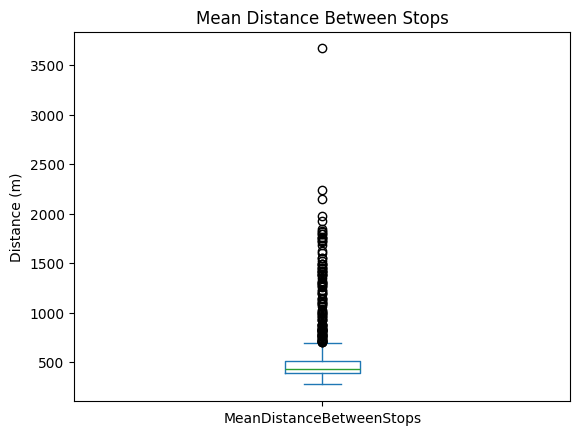

Some outliers:
    ServiceNo  Direction  MeanDistanceBetweenStops   z_score
572      858B          1               3670.000000  9.367749
466       661          2               2245.454545  5.087032
465       661          1               2150.000000  4.800194
449       651          2               1976.923077  4.280103
407       513          1               1930.769231  4.141412
Number of outliers: 21


In [144]:
# Step 1: Sort by ServiceNo, Direction, and StopSequence to ensure the order is correct
bus_routes_df_sorted = bus_routes_df.sort_values(by=['ServiceNo', 'Direction', 'StopSequence'])

# Step 2: Calculate the difference in Distance between consecutive stops for each ServiceNo and Direction
bus_routes_df_sorted['DistanceBetweenStops'] = bus_routes_df_sorted.groupby(['ServiceNo', 'Direction'])['Distance'].diff()

# Step 3: Calculate the mean distance between stops for each bus route (ServiceNo and Direction)
mean_distance_between_stops = bus_routes_df_sorted.groupby(['ServiceNo', 'Direction'])['DistanceBetweenStops'].mean().reset_index()

# Rename the column for clarity
mean_distance_between_stops.rename(columns={'DistanceBetweenStops': 'MeanDistanceBetweenStops'}, inplace=True)

mean_distance_between_stops['MeanDistanceBetweenStops'] = mean_distance_between_stops['MeanDistanceBetweenStops'] * 1000

# Display the result
print(mean_distance_between_stops.head())

# Examine the outliers
mean_distance_between_stops['MeanDistanceBetweenStops'].plot(kind='box')
plt.title('Mean Distance Between Stops')
plt.ylabel('Distance (m)')
plt.show()

# Put the outliers in a df, using z-score
mean_distance_between_stops['z_score'] = np.abs((mean_distance_between_stops['MeanDistanceBetweenStops'] - mean_distance_between_stops['MeanDistanceBetweenStops'].mean()) / mean_distance_between_stops['MeanDistanceBetweenStops'].std())
outliers = mean_distance_between_stops[mean_distance_between_stops['z_score'] > 3]
outliers = outliers.sort_values(by='MeanDistanceBetweenStops', ascending=False)
print("Some outliers:")
print(outliers.head())
print("Number of outliers:", outliers.shape[0])


From the data above, we can see that most of the buses that have a relatively long distance are those with express services (those that travel the expressway). So to handle these data, we will just filter out the outliers.

In [145]:
#Filter out the outliers based on the boxplot
mean_distance_between_stops_filtered = mean_distance_between_stops[mean_distance_between_stops['z_score'] <= 3]
true_mean_distance = mean_distance_between_stops_filtered['MeanDistanceBetweenStops'].mean()
print(f"Mean Distance between stops after filtering: {true_mean_distance:.2f} m")


Mean Distance between stops after filtering: 512.75 m


Using the optimal distance found, we can assume that bus stops within 1 MRT station can be tagged as a MRT bus stop. So presumably, if the bus stop is ~500m away from the MRT, technically we can assume that it is sufficiently close to walk to a MRT station.

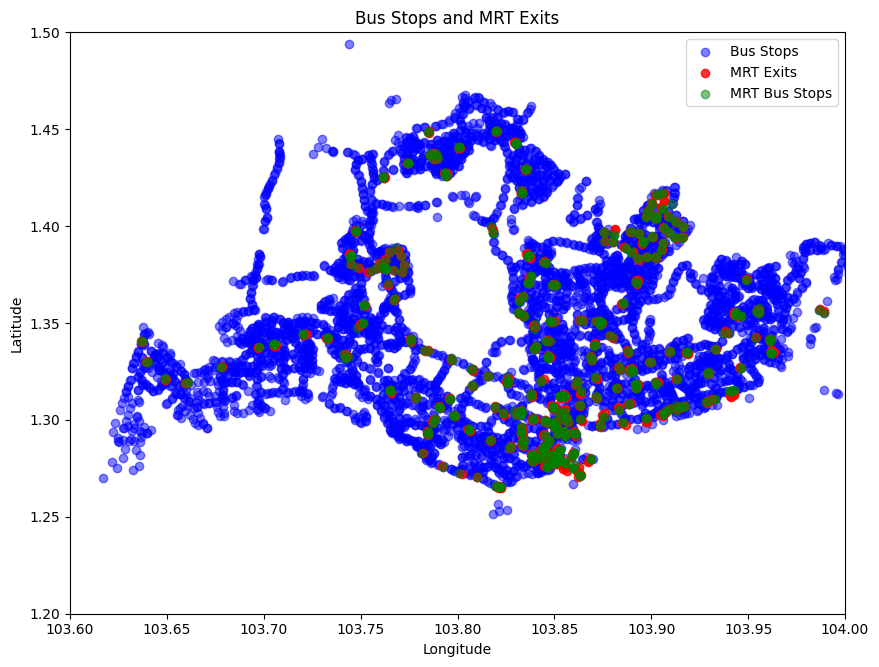

Bus stops tagged as MRT based on geospatial matching (within 30 meters): 339
Total bus stops tagged as MRT (combined methods): 339
Total number of bus stops: 5137
Percentage of bus stops tagged as MRT: 6.60%


In [150]:
def tagging_mrt_to_bus_stops(mrt_exits_gdf, bus_stops_gdf, distance = true_mean_distance):
    # Set CRS if not already defined
    if mrt_exits_gdf.crs is None:
        mrt_exits_gdf = mrt_exits_gdf.set_crs(epsg=3414)  # Use SVY21 (Singapore)
    if bus_stops_gdf.crs is None:
        bus_stops_gdf = bus_stops_gdf.set_crs(epsg=4326)  # WGS84 for bus stops

    # Re-project MRT exits to EPSG:4326 (WGS84) to match bus stops
    mrt_exits_gdf = mrt_exits_gdf.to_crs(epsg=4326)

    # **Debugging: Check for any null geometries in bus stops**
    null_bus_stops = bus_stops_gdf[bus_stops_gdf.geometry.is_empty | bus_stops_gdf.geometry.isna()]
    if len(null_bus_stops) > 0:
        print(f"Warning: Found {len(null_bus_stops)} bus stops with null or empty geometries.")
    
    # Project both GeoDataFrames to a projected CRS for distance calculation (meters)
    projected_crs = "EPSG:3857"  # Mercator projection in meters
    mrt_exits_projected = mrt_exits_gdf.to_crs(projected_crs)
    bus_stops_projected = bus_stops_gdf.to_crs(projected_crs)

    # Perform a spatial join to find the nearest bus stop for each MRT exit
    nearest_bus_stops = gpd.sjoin_nearest(
        mrt_exits_projected, 
        bus_stops_projected, 
        how="inner", 
        distance_col="distance"  # Create a column for the distance between the points
    )

    # Tag bus stops that are within 30 meters as MRT-related (geospatial match)
    bus_stops_gdf['is_mrt_geospatial'] = bus_stops_projected.index.isin(
        nearest_bus_stops[nearest_bus_stops['distance'] <= distance].index_right
    )

    # Perform string matching to identify bus stops near MRT based on description
    # bus_stops_gdf['is_mrt_string_match'] = bus_stops_gdf["Description"].str.contains("stn", case=False, na=False)

    # Combine both methods to create a final tag for MRT-related bus stops
    bus_stops_gdf['is_mrt_final'] = bus_stops_gdf['is_mrt_geospatial']

    # Plot MRT exits and bus stops together
    plt.figure(figsize=(10, 8))

    # Plot bus stops (in blue)
    bus_stops_gdf.plot(ax=plt.gca(), color='blue', label='Bus Stops', alpha=0.5)

    # Plot MRT exits (in red)
    mrt_exits_gdf.plot(ax=plt.gca(), color='red', marker='o', label='MRT Exits', alpha=0.8)
    
    # Plot is_mrt_geospatial bus stops (in green)
    nearest_bus_stops_gdf = bus_stops_gdf.loc[nearest_bus_stops.index_right]
    nearest_bus_stops_gdf[nearest_bus_stops_gdf['is_mrt_geospatial']].plot(ax=plt.gca(), color='green', label='MRT Bus Stops', alpha=0.5)
    

    # Set plot limits based on Singapore's geographical bounds
    plt.xlim(103.6, 104.0)
    plt.ylim(1.2, 1.5)

    plt.legend()
    plt.title("Bus Stops and MRT Exits")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.show()

    # Count the number of bus stops tagged as MRT-related by both methods
    mrt_geospatial_count = bus_stops_gdf['is_mrt_geospatial'].sum()
    #mrt_string_count = bus_stops_gdf['is_mrt_string_match'].sum()
    total_stops = bus_stops_gdf.shape[0]
    total_mrt_bus_stops = bus_stops_gdf['is_mrt_final'].sum()

    #print(f"Bus stops tagged as MRT based on string matching: {mrt_string_count}")
    print(f"Bus stops tagged as MRT based on geospatial matching (within 30 meters): {mrt_geospatial_count}")
    print(f"Total bus stops tagged as MRT (combined methods): {total_mrt_bus_stops}")
    print(f"Total number of bus stops: {total_stops}")
    print(f"Percentage of bus stops tagged as MRT: {total_mrt_bus_stops/total_stops*100:.2f}%")

    return bus_stops_gdf

# Call the function with the MRT exits and bus stops GeoDataFrames
tagging = tagging_mrt_to_bus_stops(mrt_exits_gdf, bus_stops_gdf, true_mean_distance)


### Checking MRT stops
Just for future debugging, ensuring that our works are correct

In [148]:
bus_stops_mrt = tagging[tagging['is_mrt_final'] == True]
bus_stops_mrt = bus_stops_mrt[['BusStopCode', 'Description', 'Latitude', 'Longitude', 'geometry']]
bus_stops_mrt

,BusStopCode,Description,Latitude,Longitude,geometry
5,1059,Bugis Stn Exit B,1.300757,103.856110,POINT (103.85611 1.30076)
7,1112,Opp Bugis Stn Exit C,1.300092,103.855200,POINT (103.8552 1.30009)
8,1113,Bugis Stn Exit A,1.301173,103.856114,POINT (103.85611 1.30117)
19,1319,Lavender Stn Exit A/ICA,1.307574,103.863256,POINT (103.86326 1.30757)
32,1541,Bugis Stn Exit D,1.298865,103.857346,POINT (103.85735 1.29886)
...,...,...,...,...,...
4935,95129,Changi Airport Ter 2,1.355093,103.989220,POINT (103.98922 1.35509)
4958,96041,Upp Changi Stn/Opp SUTD,1.341552,103.961237,POINT (103.96124 1.34155)
4959,96049,Upp Changi Stn/SUTD,1.340874,103.961433,POINT (103.96143 1.34087)
4983,96169,Simei Stn,1.342262,103.953466,POINT (103.95347 1.34226)
